In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams['font.family']='Times New Roman'

In [20]:
import pandas as pd
dset = pd.read_csv(r"D:\DataSets\Smart Grid\Power System Attack Datasets (Smart Grid Monitoring Power)\binaryAllNaturalPlusNormalVsAttacks\data7.csv")
X = dset.drop('marker',axis=1)
y = dset['marker']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [21]:
X.shape,y.shape

((5236, 128), (5236,))

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler

# Define the generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(128, activation='tanh'))
    return model

# Define the discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(512, input_dim=128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Train the GAN
def train_gan(generator, discriminator, gan, X_train, latent_dim, epochs=100, batch_size=128):
    for epoch in range(epochs):
        # Generate fake samples
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise)

        # Select a random batch of real samples
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]

        # Concatenate real and fake samples
        combined_data = np.concatenate([real_data, generated_data])

        # Assign labels for real and fake samples
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_data, labels)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Display the progress
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - D loss: {d_loss[0]:.4f} - D accuracy: {d_loss[1]*100:.2f}% - G loss: {g_loss:.4f}")

# Preprocessing step to handle infinity or large values
X_array=np.array(X_train)
X_array[np.isinf(X_array)] = np.nan
X_array[np.abs(X_array) > 1e10] = np.nan
X_array = np.nan_to_num(X_array)

# Normalize the input data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_array)

# Set the random seed for reproducibility
np.random.seed(42)

# Define the latent dimension
latent_dim = 100

# Build the generator
generator = build_generator(latent_dim)

# Build the discriminator
discriminator = build_discriminator()

# Build the GAN
gan = build_gan(generator, discriminator)

# Train the GAN
train_gan(generator, discriminator, gan, X_normalized, latent_dim, epochs=100, batch_size=128)


4/4 [==============================] - 0s 4ms/step
Epoch 10/100 - D loss: 0.1611 - D accuracy: 99.61% - G loss: 3.4237
4/4 [==============================] - 0s 3ms/step
Epoch 20/100 - D loss: 3.7163 - D accuracy: 41.80% - G loss: 0.0880
4/4 [==============================] - 0s 3ms/step
Epoch 30/100 - D loss: 4.8100 - D accuracy: 24.22% - G loss: 0.0216
4/4 [==============================] - 0s 3ms/step
Epoch 40/100 - D loss: 1.2283 - D accuracy: 58.20% - G loss: 5.1782
4/4 [==============================] - 0s 3ms/step
Epoch 50/100 - D loss: 0.5712 - D accuracy: 71.09% - G loss: 4.8062
4/4 [==============================] - 0s 3ms/step
Epoch 60/100 - D loss: 0.2941 - D accuracy: 89.45% - G loss: 7.0321
4/4 [==============================] - 0s 2ms/step
Epoch 70/100 - D loss: 0.0833 - D accuracy: 98.05% - G loss: 8.5566
4/4 [==============================] - 0s 2ms/step
Epoch 80/100 - D loss: 1.4428 - D accuracy: 49.61% - G loss: 1.5114
4/4 [==============================] - 0s 3ms/st

262/262 [==============================] - 1s 2ms/step - loss: 0.3188 - accuracy: 0.9311

Discriminator accuracy: 93.11%


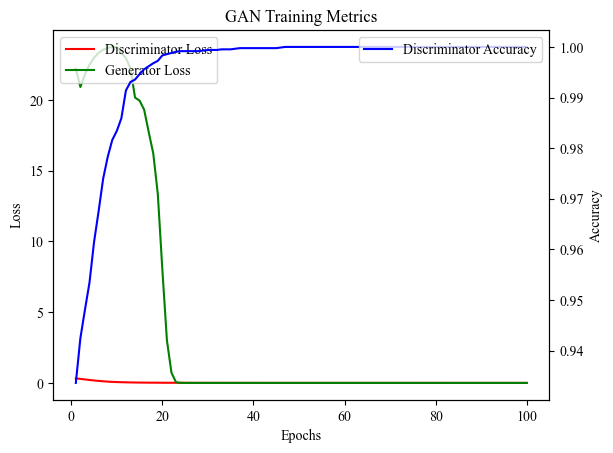

In [23]:
# Generate fake samples for evaluation
noise = np.random.normal(0, 1, (X_normalized.shape[0], latent_dim))
generated_data = generator.predict(noise)

# Concatenate real and fake samples
combined_data = np.concatenate([X_normalized, generated_data])

# Assign labels for real and fake samples
labels = np.concatenate([np.ones((X_normalized.shape[0], 1)), np.zeros((X_normalized.shape[0], 1))])

# Evaluate the discriminator
_, discriminator_accuracy = discriminator.evaluate(combined_data, labels)

print(f"\nDiscriminator accuracy: {discriminator_accuracy*100:.2f}%")

# Plot the loss versus accuracy
epochs = range(1, 101)
d_loss = []
d_accuracy = []
g_loss = []
for epoch in epochs:
    # Train the discriminator
    d_loss.append(discriminator.train_on_batch(combined_data, labels)[0])
    d_accuracy.append(discriminator.train_on_batch(combined_data, labels)[1])

    # Train the generator
    noise = np.random.normal(0, 1, (X_normalized.shape[0], latent_dim))
    g_loss.append(gan.train_on_batch(noise, np.ones((X_normalized.shape[0], 1))))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(epochs, d_loss, 'r-', label='Discriminator Loss')
ax1.plot(epochs, g_loss, 'g-', label='Generator Loss')
ax2.plot(epochs, d_accuracy, 'b-', label='Discriminator Accuracy')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('GAN Training Metrics')
plt.show()



4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step
Epoch 10/100 - D loss: 0.2270 - D accuracy: 93.75% - G loss: 25.9868
4/4 [==============================] - 0s 3ms/step
Epoch 20/100 - D loss: 0.6410 - D accuracy: 84.77% - G loss: 8.5254
4/4 [==============================] - 0s 3ms/step
Epoch 30/100 - D loss: 0.4118 - D accuracy: 86.33% - G loss: 10.0263
4/4 [==============================] - 0s 3ms/step
Epoch 40/100 - D loss: 0.3568 - D accuracy: 96.48% - G loss: 8.5783
4/4 [==============================] - 0s 2ms/step
Epoch 50/100 - D loss: 0.1366 - D accuracy: 98.05% - G loss: 10.6110
4/4 [==============================] - 0s 2ms/step
Epoch 60/100 - D loss: 0.1380 - D accuracy: 94.14% - G loss: 11.9349
4/4 [==============================] - 0s 3ms/step
Epoch 70/100 - D loss: 0.0314 - D accuracy: 99.22% - G loss: 12.8601
4/4 [==============================] - 0s 2ms/step
Epoch 80/100 - D loss: 0.0652 - D accuracy: 99.22% - G loss: 8.4359
4/4 [==============================] - 0s 3

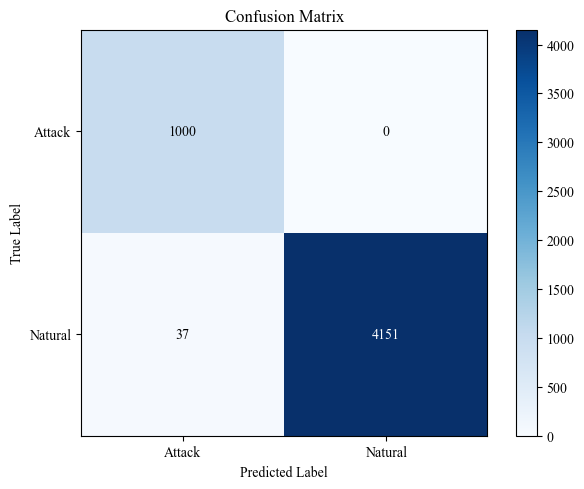

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ...

# Train the GAN
train_gan(generator, discriminator, gan, X_normalized, latent_dim, epochs=100, batch_size=128)

# Generate fake samples for evaluation
num_samples = 1000
noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_data = generator.predict(noise)

# Create labels for fake and real samples
fake_labels = np.zeros(num_samples)
real_labels = np.ones(X_normalized.shape[0])
labels = np.concatenate([real_labels, fake_labels])

# Create combined data for confusion matrix
combined_data = np.concatenate([X_normalized, generated_data])

# Predict the labels using the discriminator
predicted_labels = discriminator.predict(combined_data)

# Create confusion matrix
confusion = confusion_matrix(labels, predicted_labels.round())

# Plot confusion matrix
plt.imshow(confusion, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Attack', 'Natural'])
plt.yticks(tick_marks, ['Attack', 'Natural'])

# Fill in the values
thresh = confusion.max() / 2
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'), ha="center", va="center", color="white" if confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
